# Constructing our Minimum-Covariance Portfolios

We will be constructing our portfolios by selecting the assets which have the lowest correlations between each other. We will rebalance semi-annually based on these selections, and at each rebalance, ensure that our portfolio is split among the two geographies 50/50 

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Data Preprocessing

In [2]:
# Remove 1st line since they are pct changes, therefore have
# NaNs in the first row
rets = pd.read_csv("data/returns.csv")[1:]

# Reindex to date
rets.index = pd.to_datetime(rets['Date'])
del rets['Date']

# Delete any outliers
rets[rets > 1] = 0
rets[rets < -1] = 0

In [3]:
# read the risk free rate
riskfree = pd.read_csv("data/3mTbill.csv")
riskfree['Date'] = pd.to_datetime(riskfree['Date'])

# match the date
riskfree = riskfree[riskfree['Date'].isin(rets.index.values)].set_index('Date')

# daily risk free
riskfree = ((1 + riskfree/100).pow(1/252)-1)

In [4]:
# benchmark index (MSCI ACWI Index)
benchmark = pd.read_csv("data/benchmark.csv")
benchmark['Date'] = pd.to_datetime(benchmark['Date'])

# calculate returns
benchmark['return'] = benchmark['Adj_Close'].pct_change()

# match the date
benchmark = benchmark[benchmark['Date'].isin(rets.index.values)].set_index('Date')

# calculate excess returns
rf_bm = riskfree[riskfree.index.isin(benchmark.index.values)]
benchmark_ret = benchmark['return']
benchmark_excess = benchmark['return'].subtract(rf_bm['RFR'], axis=0)

In [5]:
# Create a list of semiannual dates to split on
rets_bt = rets[rets.index <= '2016-02-28']
dates_to_split = pd.date_range(rets_bt.index[0], rets_bt.index[-1], freq='M')

# Split on these dates
semiannual_bt = {}

for i in range(len(dates_to_split)-1):
    semiannual_bt[i] = rets_bt[dates_to_split[i]:dates_to_split[i+1]]

rets_p = rets[rets.index >= '2016-02-28']
dates_to_split = pd.date_range(rets_p.index[0], rets_p.index[-1], freq='M')

# Split on these dates
semiannual_p = {}

for i in range(len(dates_to_split)-1):
    #print(dates_to_split[i+1])
    semiannual_p[i] = rets_p[dates_to_split[i]:dates_to_split[i+1]]

# Lowest correlation Search

In [36]:
top10_bt = {}
for i in range(1,len(semiannual_bt)):
    corrs =  ((1+semiannual_bt[i-1]).cumprod()-1).iloc[-1]
    
    top10_bt[i] = [x for x in corrs.sort_values(ascending = False,axis=0).index if "USA_" in x][:10]
    top10_bt[i] += [x for x in corrs.sort_values(ascending = False,axis=0).index if "CAN_" in x][:10]

top15_bt = {}
for i in range(1,len(semiannual_bt)):
    corrs = ((1+semiannual_bt[i-1]).cumprod()-1).iloc[-1]
    
    top15_bt[i] = [x for x in corrs.sort_values(ascending = False,axis=0).index if "USA_" in x][:15]
    top15_bt[i] += [x for x in corrs.sort_values(ascending = False,axis=0).index if "CAN_" in x][:15]

top20_bt = {}
for i in range(1,len(semiannual_bt)):
    corrs = ((1+semiannual_bt[i-1]).cumprod()-1).iloc[-1]
    
    top20_bt[i] = [x for x in corrs.sort_values(ascending = False,axis=0).index if "USA_" in x][:20]
    top20_bt[i] += [x for x in corrs.sort_values(ascending = False, axis=0).index if "CAN_" in x][:20]

top10_p = {}
for i in range(1,len(semiannual_p)):
    corrs =  ((1+semiannual_p[i-1]).cumprod()-1).iloc[-1]
    
    top10_p[i] = [x for x in corrs.sort_values(ascending = False,axis=0).index if "USA_" in x][:10]
    top10_p[i] += [x for x in corrs.sort_values(ascending = False,axis=0).index if "CAN_" in x][:10]

top15_p = {}
for i in range(1,len(semiannual_p)):
    corrs = ((1+semiannual_p[i-1]).cumprod()-1).iloc[-1]
    
    top15_p[i] = [x for x in corrs.sort_values(ascending = False,axis=0).index if "USA_" in x][:15]
    top15_p[i] += [x for x in corrs.sort_values(ascending = False,axis=0).index if "CAN_" in x][:15]
    
top20_p = {}
for i in range(1,len(semiannual_p)):
    corrs = ((1+semiannual_p[i-1]).cumprod()-1).iloc[-1]
    
    top20_p[i] = [x for x in corrs.sort_values(ascending = False,axis=0).index if "USA_" in x][:20]
    top20_p[i] += [x for x in corrs.sort_values(ascending = False, axis=0).index if "CAN_" in x][:20]

# Portfolio weight optimization -- MVO, Risk Parity and Sharpe Ratio Maximization results Compare with Equally-weighted & Risk metrics, Cutoff calibration

In [62]:
# import modules 

import warnings
warnings.filterwarnings('ignore')

import portfolio_optimizer
import Risk_analytics

from importlib import reload
reload(portfolio_optimizer)
reload(Risk_analytics)

from portfolio_optimizer import portfolio_optimizer

In [8]:
# Risk mapping Parameter
VaRcutoff = {'VaR95':5000,'VaR99':5800,'CVaR95':5700,'CVaR99':5400}

10 cutoff ETFs

In [9]:
opt10_bt = portfolio_optimizer(semiannual_bt)
# MVO:
dollar_full_portfolio_mvo, PnL_mvo,usdrisk_mvo,cadrisk_mvo,overallrisk_mvo, max_drawdown_mvo,sharpe_mvo,_finalweights_mvo = opt10_bt.portfolio_simulator(100000, riskfree, top10_bt, 10, VaRcutoff, 'MVO', benchmark_excess)
# Risk parity
dollar_full_portfolio_rp, PnL_rp,usdrisk_rp,cadrisk_rp,overallrisk_rp, max_drawdown_rp,sharpe_rp,_finalweights_rp = opt10_bt.portfolio_simulator(100000, riskfree, top10_bt, 10, VaRcutoff, 'Risk parity')
# Sharpe Ratio Maximization
dollar_full_portfolio_sr, PnL_sr,usdrisk_sr,cadrisk_sr,overallrisk_sr, max_drawdown_sr,sharpe_sr,_finalweights_sr= opt10_bt.portfolio_simulator(100000, riskfree, top10_bt, 10, VaRcutoff, 'Sharpe ratio maximization')
# equally-weighted
dollar_full_portfolio_eq, PnL_eq,usdrisk_eq,cadrisk_eq,overallrisk_eq, max_drawdown_eq,sharpe_eq,_finalweights_eq = opt10_bt.portfolio_simulator(100000, riskfree, top10_bt, 10, VaRcutoff, 'Equally weighted')

In [10]:
# Benchmark PnL
k = benchmark_ret
benchmark_pnl = pd.DataFrame()
benchmark_pnl['return'] = k
benchmark_pnl['capital'] = 100000
dates_to_split = pd.date_range(rets.index[0], rets.index[-1], freq='6M')
for i in range(len(dates_to_split)-1):
    benchmark_pnl.loc[dates_to_split[i]:dates_to_split[i+1],'capital'] = 100000+ (i+1)*10000
benchmark_pnl.loc[dates_to_split[len(dates_to_split)-1]:,'capital']=  100000+ len(dates_to_split)*10000
benchmark_pnl['PnL'] = benchmark_pnl['return']*benchmark_pnl['capital']

benchmark_pnl_bt = benchmark_pnl[benchmark_pnl.index <= '03/31/2016']
benchmark_pnl_p = benchmark_pnl[benchmark_pnl.index >= '03/31/2016']

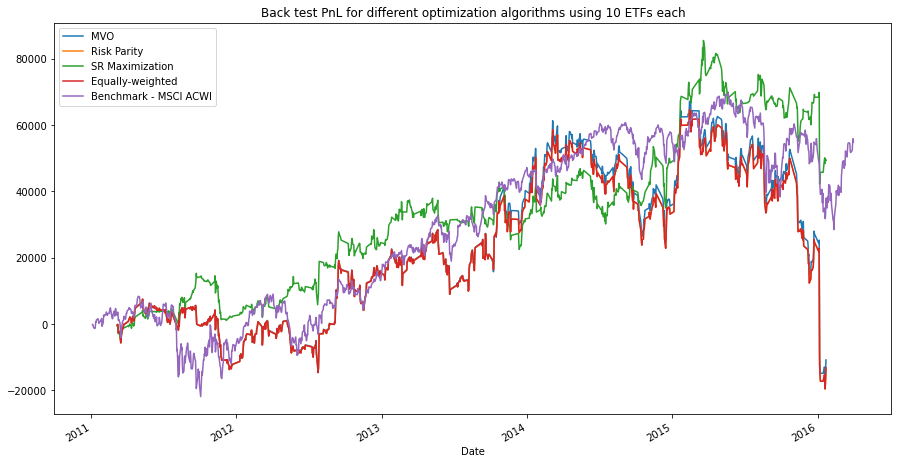

In [11]:
PnL_mvo.cumsum().plot(figsize=(15,8), label='MVO')
PnL_rp.cumsum().plot(figsize=(15,8), label='Risk Parity')
PnL_sr.cumsum().plot(figsize=(15,8), label='SR Maximization')
PnL_eq.cumsum().plot(figsize=(15,8), label='Equally-weighted')
benchmark_pnl_bt['PnL'].cumsum().plot(figsize=(15,8), label='Benchmark - MSCI ACWI')

plt.title('Back test PnL for different optimization algorithms using 10 ETFs each')
plt.legend()
plt.show()

Text(0.5, 1.0, 'Dollar value for each ETF for MVO using 10 ETFs each')

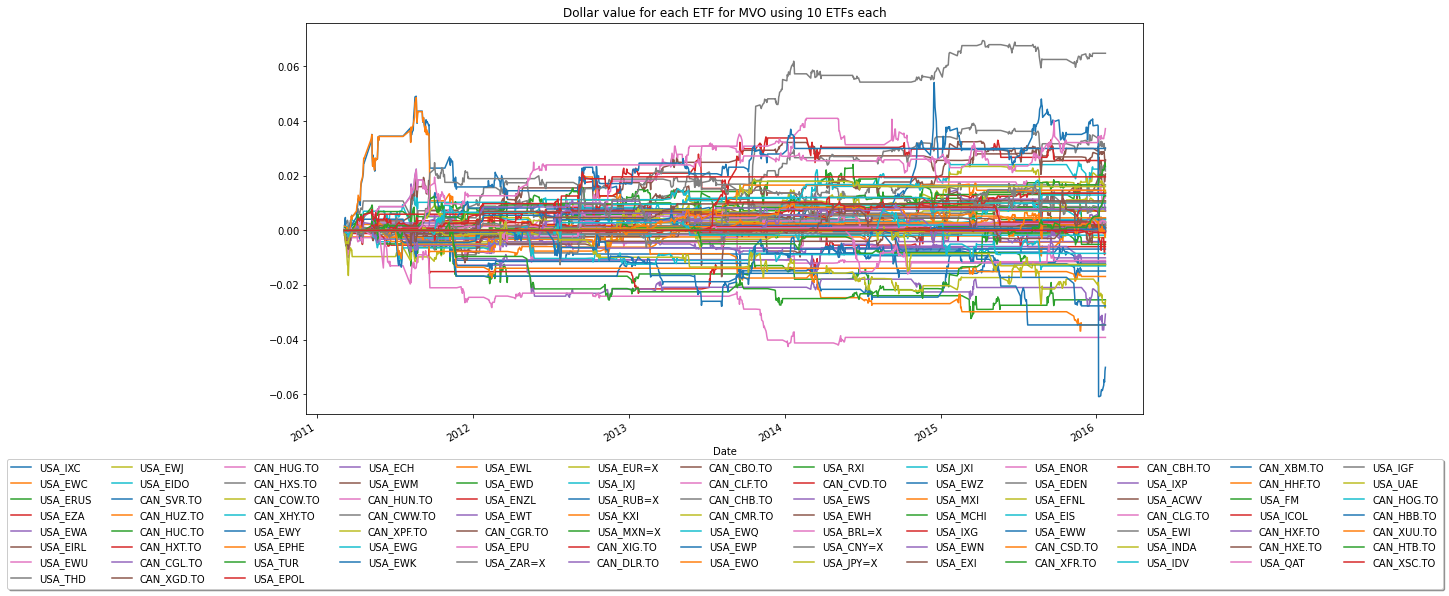

In [12]:
dollar_full_portfolio_mvo.cumsum().plot(figsize = (15,8))
plt.legend(loc="upper center", bbox_to_anchor=(0.5, -0.1), 
           fancybox=True, shadow=True, ncol=round(len(dollar_full_portfolio_mvo.columns)/7))
plt.title('Dollar value for each ETF for MVO using 10 ETFs each')

Text(0.5, 1.0, 'Dollar value for each ETF for Risk parity using 10 ETFs each')

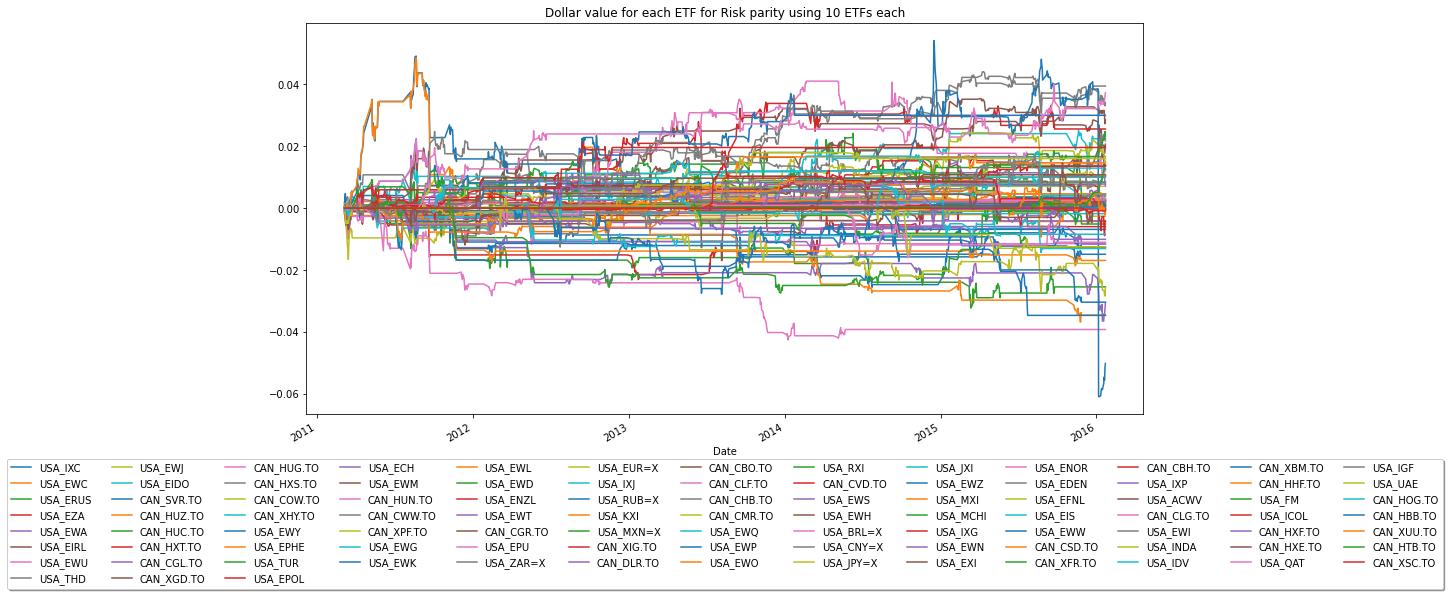

In [13]:
dollar_full_portfolio_rp.cumsum().plot(figsize = (15,8))
plt.legend(loc="upper center", bbox_to_anchor=(0.5, -0.1), 
           fancybox=True, shadow=True, ncol=round(len(dollar_full_portfolio_rp.columns)/7))
plt.title('Dollar value for each ETF for Risk parity using 10 ETFs each')

Text(0.5, 1.0, 'Dollar value for each ETF for SR maximization using 10 ETFs each')

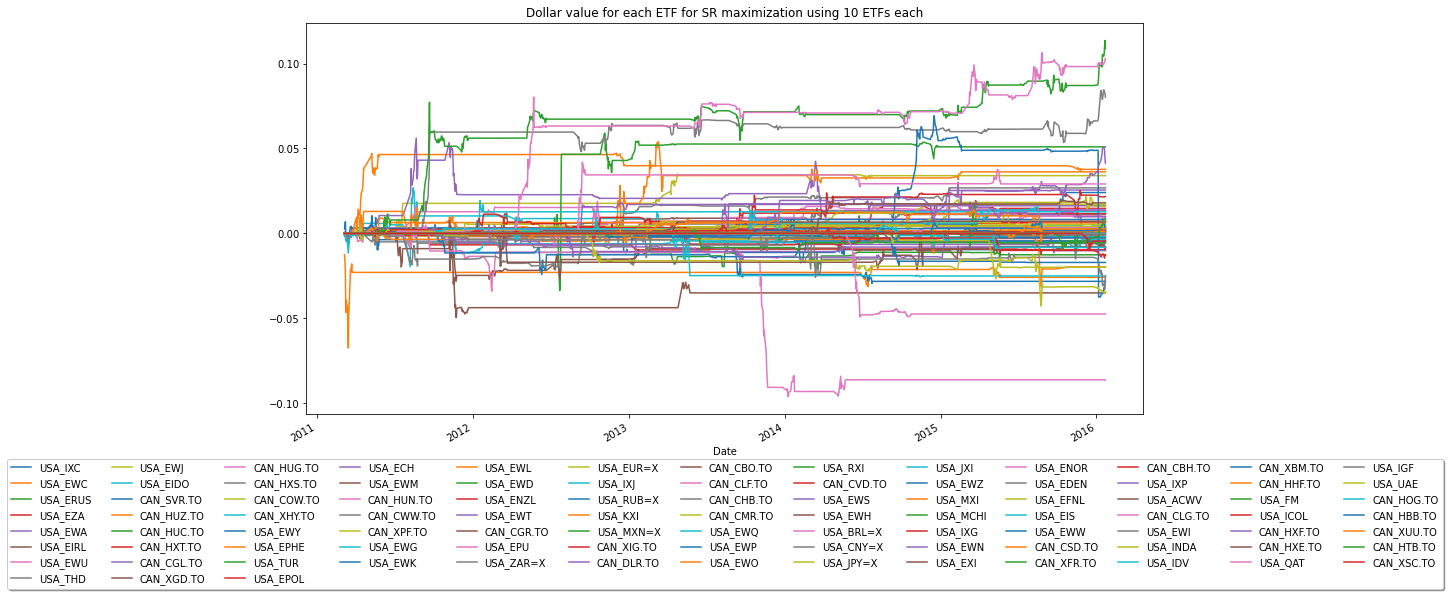

In [14]:
dollar_full_portfolio_sr.cumsum().plot(figsize = (15,8))
plt.legend(loc="upper center", bbox_to_anchor=(0.5, -0.1), 
           fancybox=True, shadow=True, ncol=round(len(dollar_full_portfolio_sr.columns)/7))
plt.title('Dollar value for each ETF for SR maximization using 10 ETFs each')

Text(0.5, 1.0, 'Dollar value for each ETF for equally-weighted using 10 ETFs each')

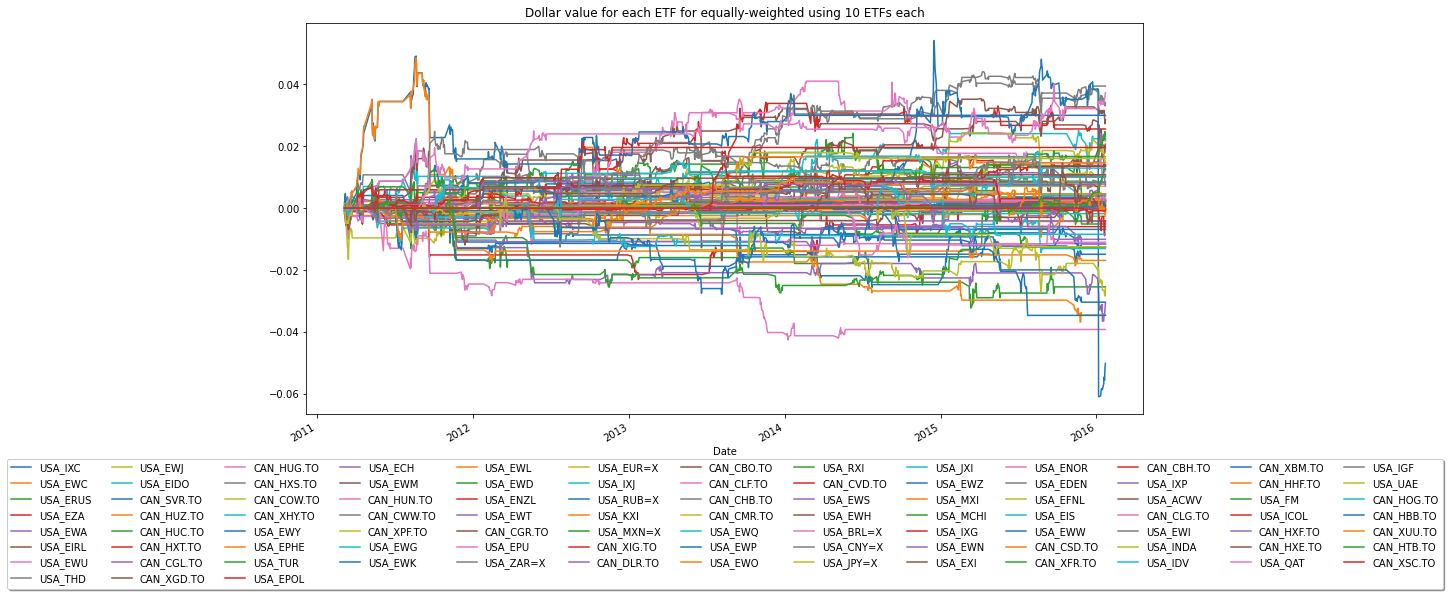

In [15]:
dollar_full_portfolio_eq.cumsum().plot(figsize = (15,8))
plt.legend(loc="upper center", bbox_to_anchor=(0.5, -0.1), 
           fancybox=True, shadow=True, ncol=round(len(dollar_full_portfolio_eq.columns)/7))
plt.title('Dollar value for each ETF for equally-weighted using 10 ETFs each')

In [16]:
opt10_p = portfolio_optimizer(semiannual_p)
# MVO:
dollar_full_portfolio_mvo, PnL_mvo,usdrisk_mvo,cadrisk_mvo,overallrisk_mvo, max_drawdown_mvo,sharpe_mvo,_finalweights_mvo = opt10_p.portfolio_simulator(100000, riskfree, top10_p, 10, VaRcutoff, 'MVO', benchmark_excess)
# Risk parity
dollar_full_portfolio_rp, PnL_rp,usdrisk_rp,cadrisk_rp,overallrisk_rp, max_drawdown_rp,sharpe_rp,_finalweights_rp = opt10_p.portfolio_simulator(100000, riskfree, top10_p, 10, VaRcutoff, 'Risk parity')
# Sharpe Ratio Maximization
dollar_full_portfolio_sr, PnL_sr,usdrisk_sr,cadrisk_sr,overallrisk_sr, max_drawdown_sr,sharpe_sr,_finalweights_sr= opt10_p.portfolio_simulator(100000, riskfree, top10_p, 10, VaRcutoff, 'Sharpe ratio maximization')
# equally-weighted
dollar_full_portfolio_eq, PnL_eq,usdrisk_eq,cadrisk_eq,overallrisk_eq, max_drawdown_eq,sharpe_eq,_finalweights_eq = opt10_p.portfolio_simulator(100000, riskfree, top10_p, 10, VaRcutoff, 'Equally weighted')

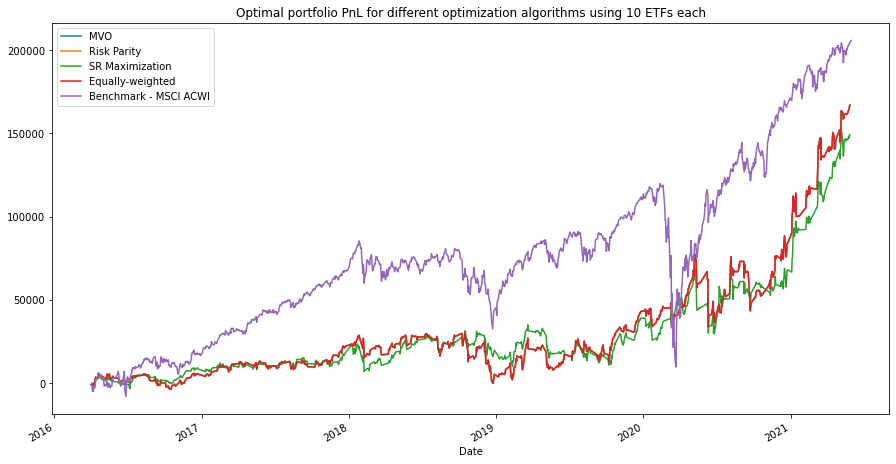

In [17]:
PnL_mvo.cumsum().plot(figsize=(15,8), label='MVO')
PnL_rp.cumsum().plot(figsize=(15,8), label='Risk Parity')
PnL_sr.cumsum().plot(figsize=(15,8), label='SR Maximization')
PnL_eq.cumsum().plot(figsize=(15,8), label='Equally-weighted')
benchmark_pnl_p['PnL'].cumsum().plot(figsize=(15,8), label='Benchmark - MSCI ACWI')

plt.title('Optimal portfolio PnL for different optimization algorithms using 10 ETFs each')
plt.legend()
plt.show()

15 cutoff ETFs

In [18]:
opt15_bt = portfolio_optimizer(semiannual_bt)
# MVO:
dollar_full_portfolio_mvo, PnL_mvo,usdrisk_mvo,cadrisk_mvo,overallrisk_mvo, max_drawdown_mvo,sharpe_mvo,_finalweights_mvo = opt15_bt.portfolio_simulator(100000, riskfree, top15_bt, 15, VaRcutoff, 'MVO', benchmark_excess)
# Risk parity
dollar_full_portfolio_rp, PnL_rp,usdrisk_rp,cadrisk_rp,overallrisk_rp, max_drawdown_rp,sharpe_rp,_finalweights_rp = opt15_bt.portfolio_simulator(100000, riskfree, top15_bt, 15, VaRcutoff, 'Risk parity')
# Sharpe Ratio Maximization
dollar_full_portfolio_sr, PnL_sr,usdrisk_sr,cadrisk_sr,overallrisk_sr, max_drawdown_sr,sharpe_sr,_finalweights_sr= opt15_bt.portfolio_simulator(100000, riskfree, top15_bt, 15, VaRcutoff, 'Sharpe ratio maximization')
# equally-weighted
dollar_full_portfolio_eq, PnL_eq,usdrisk_eq,cadrisk_eq,overallrisk_eq, max_drawdown_eq,sharpe_eq,_finalweights_eq = opt15_bt.portfolio_simulator(100000, riskfree, top15_bt, 15, VaRcutoff, 'Equally weighted')

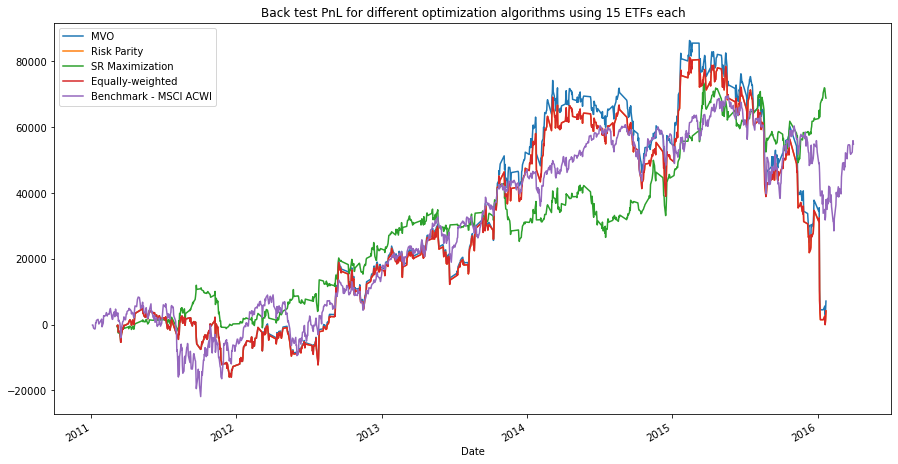

In [19]:
PnL_mvo.cumsum().plot(figsize=(15,8), label='MVO')
PnL_rp.cumsum().plot(figsize=(15,8), label='Risk Parity')
PnL_sr.cumsum().plot(figsize=(15,8), label='SR Maximization')
PnL_eq.cumsum().plot(figsize=(15,8), label='Equally-weighted')
benchmark_pnl_bt['PnL'].cumsum().plot(figsize=(15,8), label='Benchmark - MSCI ACWI')

plt.title('Back test PnL for different optimization algorithms using 15 ETFs each')
plt.legend()
plt.show()

Text(0.5, 1.0, 'Dollar value for each ETF for MVO using 15 ETFs each')

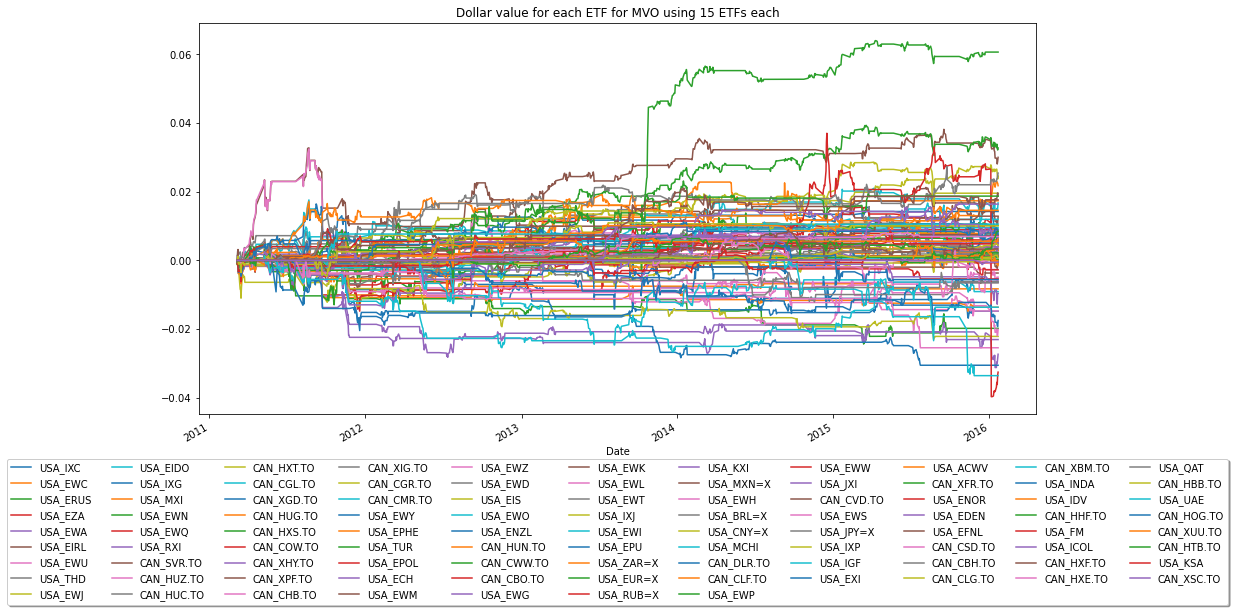

In [20]:
dollar_full_portfolio_mvo.cumsum().plot(figsize = (15,8))
plt.legend(loc="upper center", bbox_to_anchor=(0.5, -0.1), 
           fancybox=True, shadow=True, ncol=round(len(dollar_full_portfolio_mvo.columns)/9))
plt.title('Dollar value for each ETF for MVO using 15 ETFs each')

Text(0.5, 1.0, 'Dollar value for each ETF for Risk parity using 15 ETFs each')

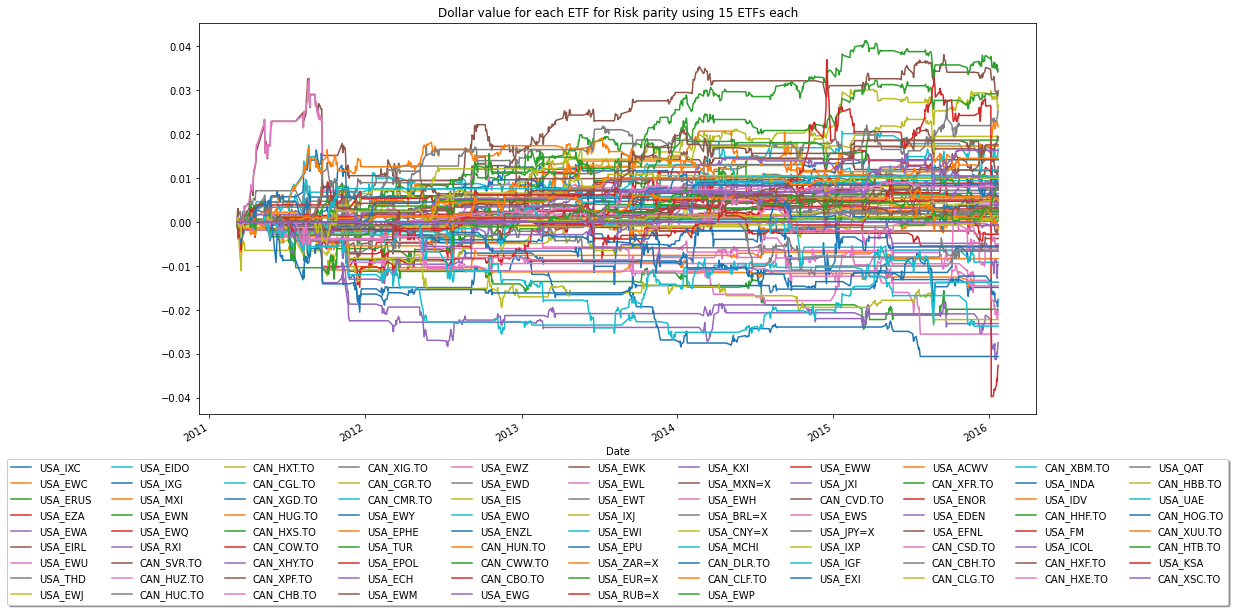

In [21]:
dollar_full_portfolio_rp.cumsum().plot(figsize = (15,8))
plt.legend(loc="upper center", bbox_to_anchor=(0.5, -0.1), 
           fancybox=True, shadow=True, ncol=round(len(dollar_full_portfolio_rp.columns)/9))
plt.title('Dollar value for each ETF for Risk parity using 15 ETFs each')

Text(0.5, 1.0, 'Dollar value for each ETF for SR maximization using 15 ETFs each')

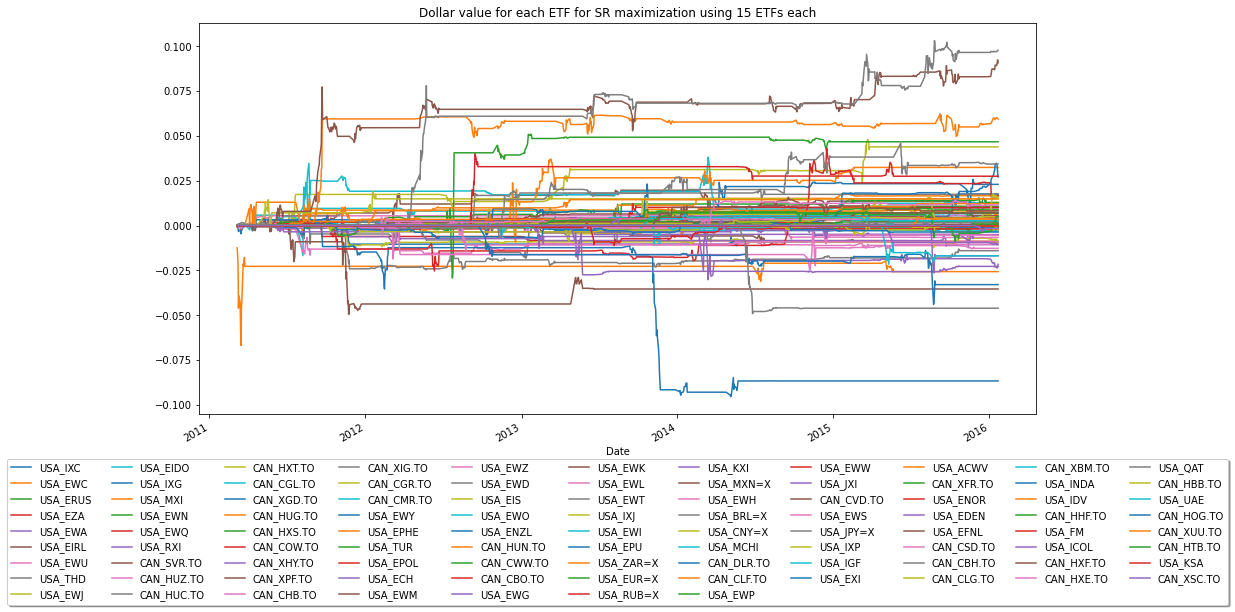

In [22]:
dollar_full_portfolio_sr.cumsum().plot(figsize = (15,8))
plt.legend(loc="upper center", bbox_to_anchor=(0.5, -0.1), 
           fancybox=True, shadow=True, ncol=round(len(dollar_full_portfolio_sr.columns)/9))
plt.title('Dollar value for each ETF for SR maximization using 15 ETFs each')

Text(0.5, 1.0, 'Dollar value for each ETF for equally-weighted using 15 ETFs each')

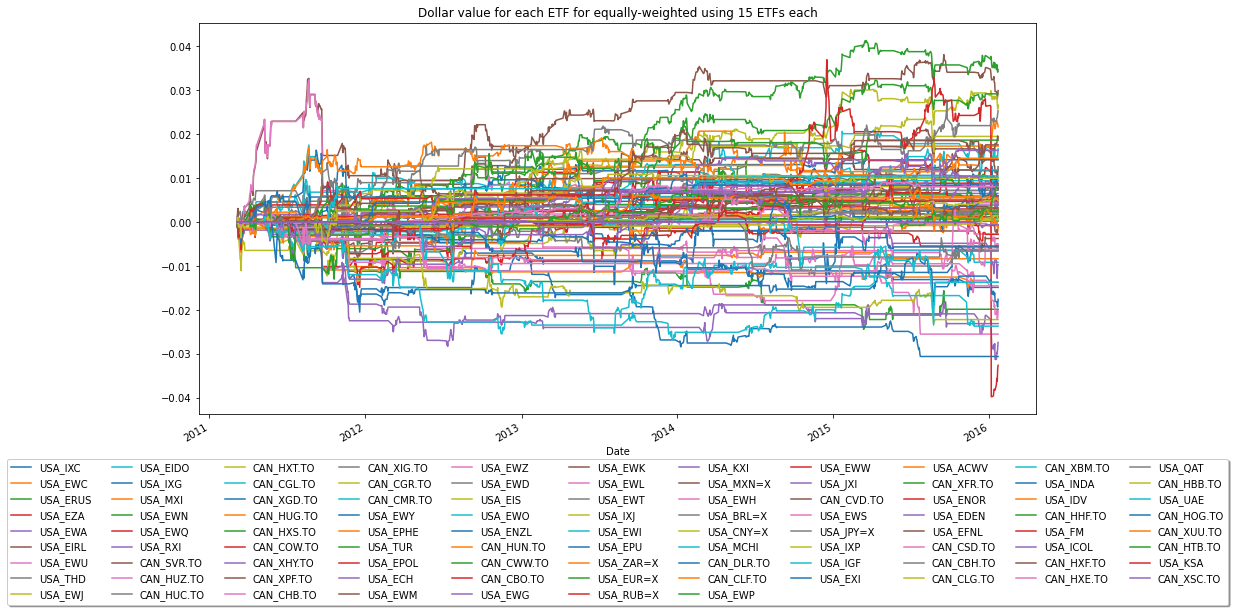

In [23]:
dollar_full_portfolio_eq.cumsum().plot(figsize = (15,8))
plt.legend(loc="upper center", bbox_to_anchor=(0.5, -0.1), 
           fancybox=True, shadow=True, ncol=round(len(dollar_full_portfolio_eq.columns)/9))
plt.title('Dollar value for each ETF for equally-weighted using 15 ETFs each')

In [24]:
opt15_p = portfolio_optimizer(semiannual_p)
# MVO:
dollar_full_portfolio_mvo, PnL_mvo,usdrisk_mvo,cadrisk_mvo,overallrisk_mvo, max_drawdown_mvo,sharpe_mvo,_finalweights_mvo = opt15_p.portfolio_simulator(100000, riskfree, top15_p, 15, VaRcutoff, 'MVO', benchmark_excess)
# Risk parity
dollar_full_portfolio_rp, PnL_rp,usdrisk_rp,cadrisk_rp,overallrisk_rp, max_drawdown_rp,sharpe_rp,_finalweights_rp = opt15_p.portfolio_simulator(100000, riskfree, top15_p, 15, VaRcutoff, 'Risk parity')
# Sharpe Ratio Maximization
dollar_full_portfolio_sr, PnL_sr,usdrisk_sr,cadrisk_sr,overallrisk_sr, max_drawdown_sr,sharpe_sr,_finalweights_sr= opt15_p.portfolio_simulator(100000, riskfree, top15_p, 15, VaRcutoff, 'Sharpe ratio maximization')
# equally-weighted
dollar_full_portfolio_eq, PnL_eq,usdrisk_eq,cadrisk_eq,overallrisk_eq, max_drawdown_eq,sharpe_eq,_finalweights_eq = opt15_p.portfolio_simulator(100000, riskfree, top15_p, 15, VaRcutoff, 'Equally weighted')

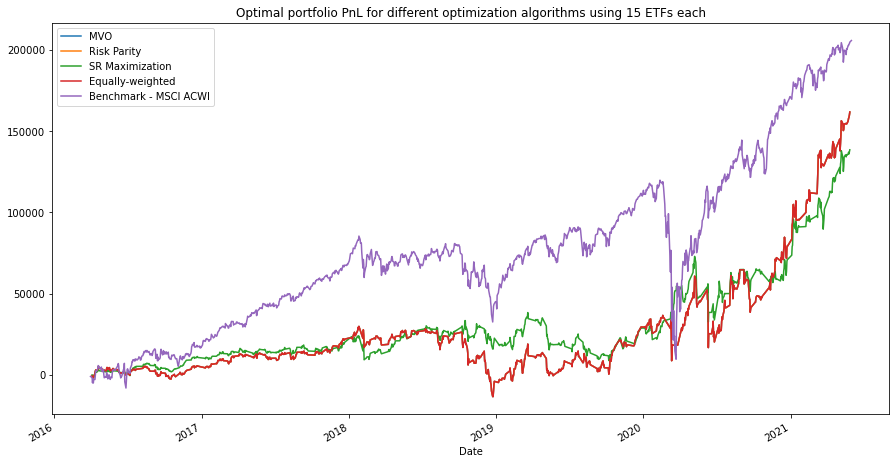

In [25]:
PnL_mvo.cumsum().plot(figsize=(15,8), label='MVO')
PnL_rp.cumsum().plot(figsize=(15,8), label='Risk Parity')
PnL_sr.cumsum().plot(figsize=(15,8), label='SR Maximization')
PnL_eq.cumsum().plot(figsize=(15,8), label='Equally-weighted')
benchmark_pnl_p['PnL'].cumsum().plot(figsize=(15,8), label='Benchmark - MSCI ACWI')

plt.title('Optimal portfolio PnL for different optimization algorithms using 15 ETFs each')
plt.legend()
plt.show()

20 cutoff ETFs

In [37]:
opt20_bt = portfolio_optimizer(semiannual_bt)

# MVO:
dollar_full_portfolio_mvo, PnL_mvo,usdrisk_mvo,cadrisk_mvo,overallrisk_mvo, max_drawdown_mvo,sharpe_mvo,_finalweights_mvo = opt20_bt.portfolio_simulator(100000, riskfree, top20_bt, 20,VaRcutoff, 'MVO', benchmark_excess)
# Risk parity
dollar_full_portfolio_rp, PnL_rp,usdrisk_rp,cadrisk_rp,overallrisk_rp, max_drawdown_rp,sharpe_rp,_finalweights_rp = opt20_bt.portfolio_simulator(100000, riskfree, top20_bt, 20,VaRcutoff, 'Risk parity')
# Sharpe Ratio Maximization
dollar_full_portfolio_sr, PnL_sr,usdrisk_sr,cadrisk_sr,overallrisk_sr, max_drawdown_sr,sharpe_sr,_finalweights_sr = opt20_bt.portfolio_simulator(100000, riskfree, top20_bt, 20,VaRcutoff, 'Sharpe ratio maximization')
# equally-weighted
dollar_full_portfolio_eq, PnL_eq,usdrisk_eq,cadrisk_eq,overallrisk_eq, max_drawdown_eq,sharpe_eq,_finalweights_eq = opt20_bt.portfolio_simulator(100000, riskfree, top20_bt, 20, VaRcutoff, 'Equally weighted')

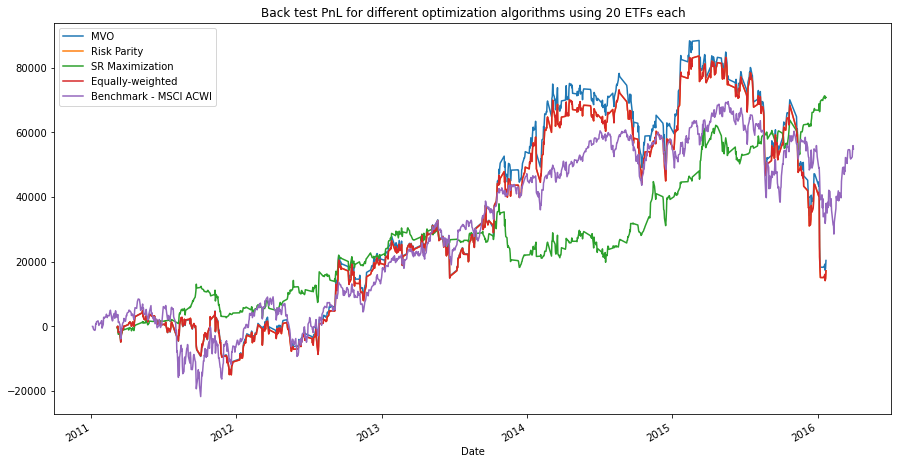

In [38]:
PnL_mvo.cumsum().plot(figsize=(15,8), label='MVO')
PnL_rp.cumsum().plot(figsize=(15,8), label='Risk Parity')
PnL_sr.cumsum().plot(figsize=(15,8), label='SR Maximization')
PnL_eq.cumsum().plot(figsize=(15,8), label='Equally-weighted')
benchmark_pnl_bt['PnL'].cumsum().plot(figsize=(15,8), label='Benchmark - MSCI ACWI')

plt.title('Back test PnL for different optimization algorithms using 20 ETFs each')
plt.legend()
plt.show()

Text(0.5, 1.0, 'Dollar value for each ETF for MVO using 20 ETFs each')

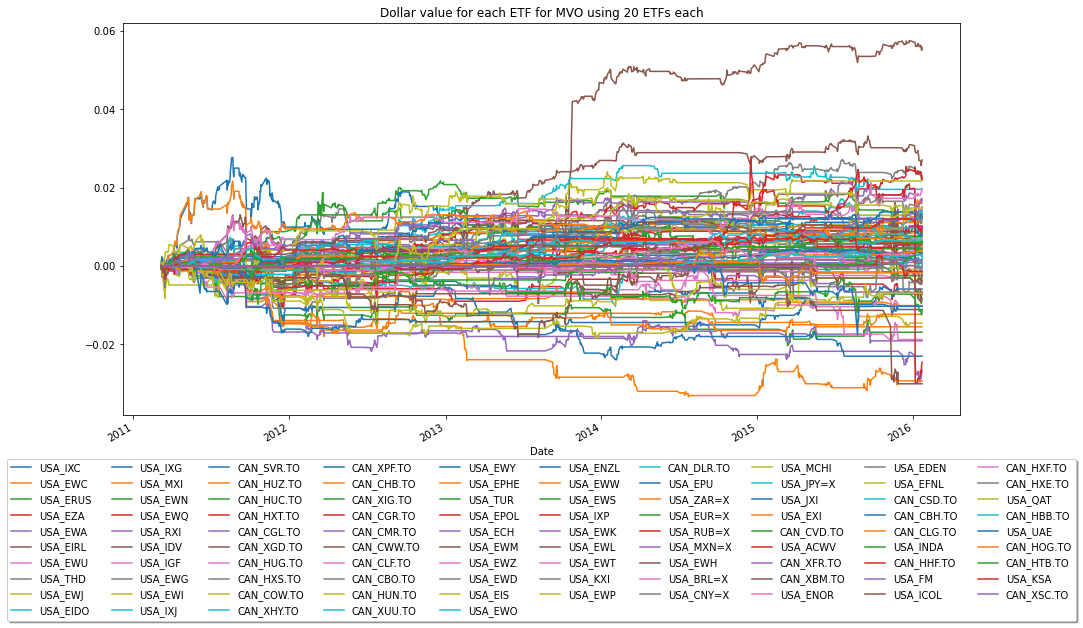

In [39]:
dollar_full_portfolio_mvo.cumsum().plot(figsize = (15,8))
plt.legend(loc="upper center", bbox_to_anchor=(0.5, -0.1), 
           fancybox=True, shadow=True, ncol=round(len(dollar_full_portfolio_mvo.columns)/10))
plt.title('Dollar value for each ETF for MVO using 20 ETFs each')

Text(0.5, 1.0, 'Dollar value for each ETF for Risk parity using 20 ETFs each')

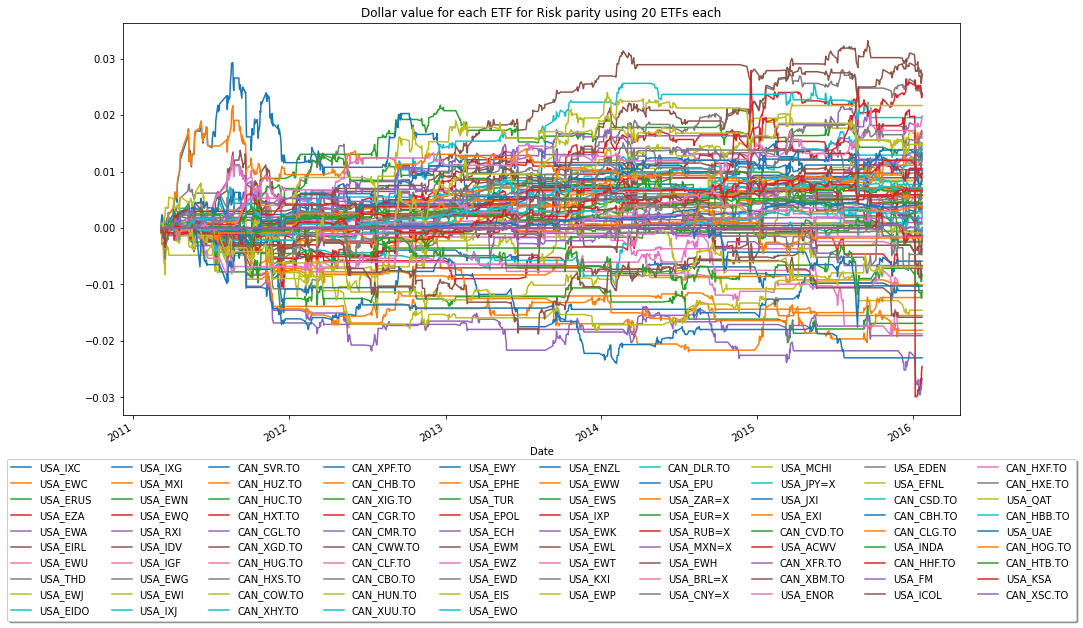

In [40]:
dollar_full_portfolio_rp.cumsum().plot(figsize = (15,8))
plt.legend(loc="upper center", bbox_to_anchor=(0.5, -0.1), 
           fancybox=True, shadow=True, ncol=round(len(dollar_full_portfolio_rp.columns)/10))
plt.title('Dollar value for each ETF for Risk parity using 20 ETFs each')

Text(0.5, 1.0, 'Dollar value for each ETF for SR maximization using 20 ETFs each')

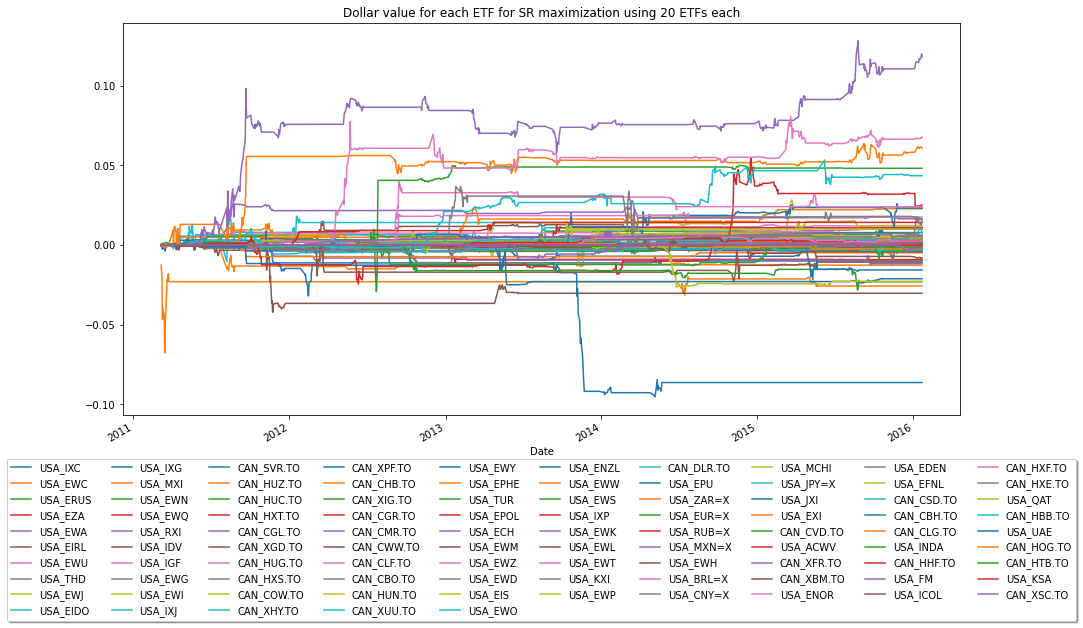

In [41]:
dollar_full_portfolio_sr.cumsum().plot(figsize = (15,8))
plt.legend(loc="upper center", bbox_to_anchor=(0.5, -0.1), 
           fancybox=True, shadow=True, ncol=round(len(dollar_full_portfolio_sr.columns)/10))
plt.title('Dollar value for each ETF for SR maximization using 20 ETFs each')

Text(0.5, 1.0, 'Dollar value for each ETF for equally-weighted using 20 ETFs each')

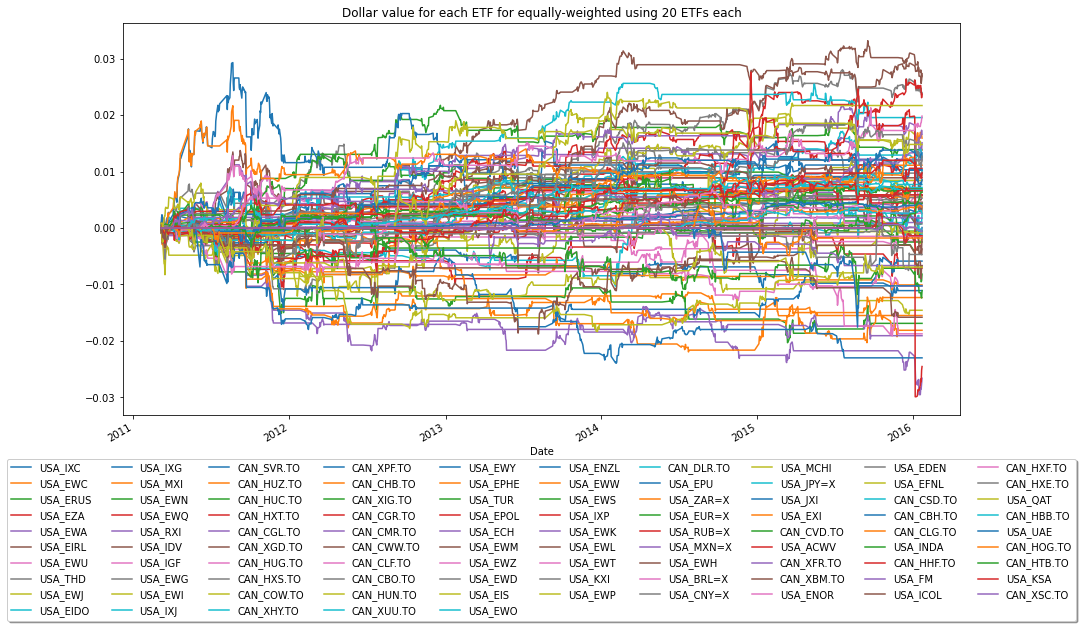

In [42]:
dollar_full_portfolio_eq.cumsum().plot(figsize = (15,8))
plt.legend(loc="upper center", bbox_to_anchor=(0.5, -0.1), 
           fancybox=True, shadow=True, ncol=round(len(dollar_full_portfolio_eq.columns)/10))
plt.title('Dollar value for each ETF for equally-weighted using 20 ETFs each')

In [43]:
opt20_p = portfolio_optimizer(semiannual_p)
# MVO:
dollar_full_portfolio_mvo, PnL_mvo,usdrisk_mvo,cadrisk_mvo,overallrisk_mvo, max_drawdown_mvo,sharpe_mvo,_finalweights_mvo = opt20_p.portfolio_simulator(100000, riskfree, top20_p, 20, VaRcutoff, 'MVO', benchmark_excess)
# Risk parity
dollar_full_portfolio_rp, PnL_rp,usdrisk_rp,cadrisk_rp,overallrisk_rp, max_drawdown_rp,sharpe_rp,_finalweights_rp = opt20_p.portfolio_simulator(100000, riskfree, top20_p, 20, VaRcutoff, 'Risk parity')
# Sharpe Ratio Maximization
dollar_full_portfolio_sr, PnL_sr,usdrisk_sr,cadrisk_sr,overallrisk_sr, max_drawdown_sr,sharpe_sr,_finalweights_sr= opt20_p.portfolio_simulator(100000, riskfree, top20_p, 20, VaRcutoff, 'Sharpe ratio maximization')
# equally-weighted
dollar_full_portfolio_eq, PnL_eq,usdrisk_eq,cadrisk_eq,overallrisk_eq, max_drawdown_eq,sharpe_eq,_finalweights_eq = opt20_p.portfolio_simulator(100000, riskfree, top20_p, 20, VaRcutoff, 'Equally weighted')

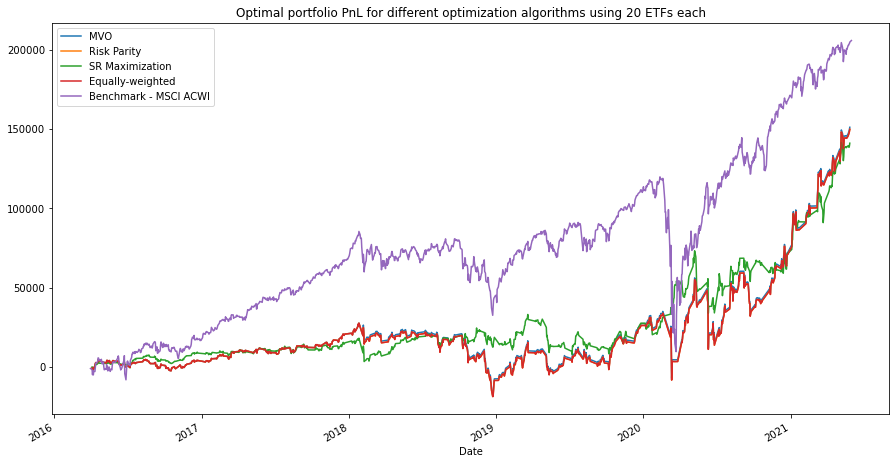

In [44]:
PnL_mvo.cumsum().plot(figsize=(15,8), label='MVO')
PnL_rp.cumsum().plot(figsize=(15,8), label='Risk Parity')
PnL_sr.cumsum().plot(figsize=(15,8), label='SR Maximization')
PnL_eq.cumsum().plot(figsize=(15,8), label='Equally-weighted')
benchmark_pnl_p['PnL'].cumsum().plot(figsize=(15,8), label='Benchmark - MSCI ACWI')

plt.title('Optimal portfolio PnL for different optimization algorithms using 20 ETFs each')
plt.legend()
plt.show()

# Scenario Analysis

We will pick time period 2012 January to 2017 December as the scenario testing period, two scenarios will be tested:
1. the entire market will crash by 0.5% with probability 2% in a single day;
2. each ETFs will randomly crash by a half with probability 5% in a single day.

In [46]:
# Market crush scenario
opt_sa1 = portfolio_optimizer(semiannual_bt)

# Risk parity
dollar_full_portfolio_rp, PnL_rp,usdrisk_rp,cadrisk_rp,overallrisk_rp, max_drawdown_rp,sharpe_rp,_finalweights_rp = opt_sa1.portfolio_simulator(100000, riskfree, top15_bt, 15, VaRcutoff, 'Risk parity', scenario='Market crash')
# Sharpe Ratio Maximization
dollar_full_portfolio_sr, PnL_sr,usdrisk_sr,cadrisk_sr,overallrisk_sr, max_drawdown_sr,sharpe_sr,_finalweights_sr = opt_sa1.portfolio_simulator(100000, riskfree, top15_bt, 15, VaRcutoff, 'Sharpe ratio maximization', scenario='Market crash')

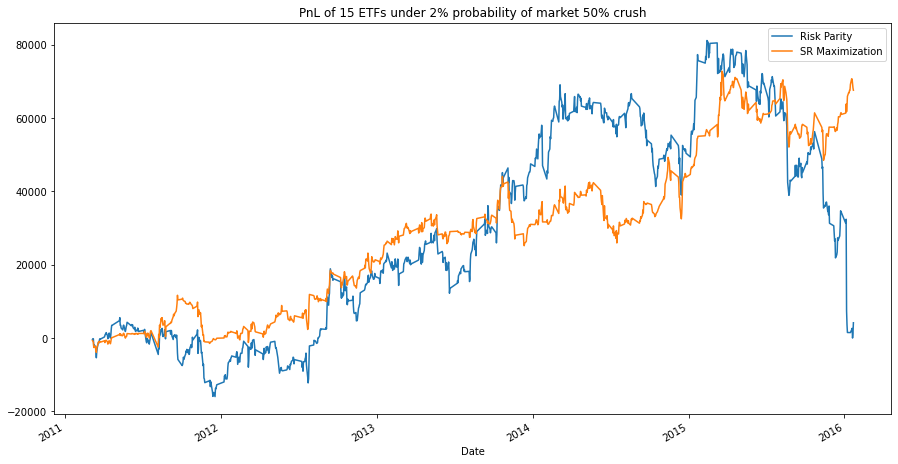

In [47]:
PnL_rp.cumsum().plot(figsize=(15,8), label='Risk Parity')
PnL_sr.cumsum().plot(figsize=(15,8), label='SR Maximization')

plt.title('PnL of 15 ETFs under 2% probability of market 50% crush')
plt.legend()
plt.show()

In [48]:
print(f'Max drawdown for Risk parity: {max_drawdown_rp}')
overallrisk_rp

Max drawdown for Risk parity: -119.66000000000001%


VaR 95%       VaR 99%      CVaR 95%      CVaR 99%
Period                                                       
1      -2039.784075  -2271.896473  -2155.840274  -2271.896473
2       -994.835637  -1801.449903  -1398.142770  -1801.449903
3      -2298.823552  -3820.796748  -3059.810150  -3820.796748
4      -1272.840232  -1408.890807  -1340.865520  -1408.890807
5      -1605.672366  -2881.302809  -2243.487588  -2881.302809
6      -5080.610193  -7318.315103  -6199.462648  -7318.315103
7      -3194.731945  -3433.688144  -3314.210044  -3433.688144
8      -1589.422804  -2760.529852  -2174.976328  -2760.529852
9      -5327.521349  -6742.995037  -6035.258193  -6742.995037
10     -2231.519658  -2360.223062  -2295.871360  -2360.223062
11     -1465.696786  -1494.757402  -1480.227094  -1494.757402
12     -1611.180787  -4551.381664  -3081.281225  -4551.381664
13     -2726.233279  -5894.418149  -4310.325714  -5894.418149
14     -1783.518835  -2036.653885  -1910.086360  -2036.653885
15     -1639.225154  -2182.528160  -1910.876657  -2182.528160
16     -1419.989536  -1850.709027  -1635.349282  -1850.709027
17     -3706.298067  -4046.376865  -3876.337466  -4046.376865
18     -2145.714226  -2779.085820  -2462.400023  -2779.085820
19     -2622.782173  -3508.532879  -3065.657526  -3508.532879
20     -3567.039327  -4803.883230  -4185.461278  -4803.883230
21     -1889.448940  -3466.482899  -2677.965920  -3466.482899
22     -1512.869445  -2732.953067  -2122.911256  -2732.953067
23     -1567.452344  -2095.136782  -1831.294563  -2095.136782
24     -4390.994177  -5507.454549  -4949.224363  -5507.454549
25     -1385.772495  -1742.044251  -1563.908373  -1742.044251
26     -2817.523364  -4309.121969  -3563.322667  -4309.121969
27     -3882.861602  -5358.588477  -4620.725040  -5358.588477
28     -4593.300353  -6049.676959  -5321.488656  -6049.676959
29     -1440.709495  -1558.721261  -1499.715378  -1558.721261
30     -3261.749997  -6816.449892  -5039.099944  -6816.449892
31     -4267.180205  -5050.959401  -4659.069803  -5050.959401
32     -2777.543129  -4141.025662  -3459.284395  -4141.025662
33     -4615.784113  -5605.068187  -5110.426150  -5605.068187
34     -1722.173722  -3014.626322  -2368.400022  -3014.626322
35     -5280.548555  -9183.809730  -7232.179142  -9183.809730
36     -1669.273488  -3798.529800  -2733.901644  -3798.529800
37     -6897.676084  -7772.143304  -7334.909694  -7772.143304
38     -2485.661446  -4154.211925  -3319.936685  -4154.211925
39     -2513.482890  -3674.761691  -3094.122291  -3674.761691
40     -2758.305750  -3189.013669  -2973.659710  -3189.013669
41     -5595.602722  -6980.988967  -6288.295844  -6980.988967
42     -2451.833899  -3667.396619  -3059.615259  -3667.396619
43     -3232.795432  -5166.172884  -4199.484158  -5166.172884
44     -3261.310280  -3898.613695  -3579.961988  -3898.613695
45     -1893.178600  -2304.497633  -2098.838116  -2304.497633
46     -4486.067784  -6333.087829  -5409.577807  -6333.087829
47     -3709.822151  -4125.117078  -3917.469614  -4125.117078
48     -7833.095294  -7833.095294  -7833.095294  -7833.095294
49     -6573.380874  -9178.024676  -7875.702775  -9178.024676
50     -3716.035396  -4305.628311  -4010.831854  -4305.628311
51     -6136.545141 -10433.959131  -8285.252136 -10433.959131
52     -3566.074651  -7263.149426  -5414.612038  -7263.149426
53     -4103.531931  -5638.665377  -4871.098654  -5638.665377
54     -7605.800339 -12710.328618 -10158.064479 -12710.328618
55     -5364.986853  -6480.569422  -5922.778137  -6480.569422
56     -2372.980650  -3060.160611  -2716.570630  -3060.160611
57     -5802.643936  -9460.293061  -7631.468498  -9460.293061
58     -3479.075847  -6187.585413  -4833.330630  -6187.585413
59     -7047.436817 -26155.690361 -16601.563589 -26155.690361

In [49]:
overallrisk_rp.sum(axis=1)

Period
1     -8739.417294
2     -5995.878213
3    -13000.227199
4     -5431.487367
5     -9611.765572
6    -25916.703047
7    -13376.318276
8     -9285.458835
9    -24848.769615
10    -9247.837142
11    -5935.438686
12   -13795.225340
13   -18825.395292
14    -7766.912964
15    -7915.158132
16    -6756.756872
17   -15675.389263
18   -10166.285888
19   -12705.505456
20   -17360.267064
21   -11500.380658
22    -9101.686834
23    -7589.020472
24   -20355.127638
25    -6433.769370
26   -14999.089970
27   -19220.763596
28   -22014.142927
29    -6057.867395
30   -21933.749725
31   -19028.168810
32   -14518.878847
33   -20936.346638
34   -10119.826388
35   -30880.347157
36   -12000.234731
37   -29776.872385
38   -14114.021980
39   -12957.128563
40   -12109.992798
41   -25845.876499
42   -12846.242396
43   -17764.625358
44   -14638.499657
45    -8601.011982
46   -22561.821249
47   -15877.525921
48   -31332.381174
49   -32805.133000
50   -16338.123873
51   -35289.715540
52   -23506.985540
53   

In [50]:
print(f'Max drawdown for Risk parity: {max_drawdown_sr}')
overallrisk_sr

Max drawdown for Risk parity: -105.36000000000001%


VaR 95%       VaR 99%     CVaR 95%      CVaR 99%
Period                                                      
1       -992.672475  -1638.033895 -1315.353185  -1638.033895
2       -719.160070   -947.088991  -833.124531   -947.088991
3       -801.340958  -1662.118637 -1231.729798  -1662.118637
4       -259.921999   -321.993361  -290.957680   -321.993361
5      -1324.383890  -1465.444356 -1394.914123  -1465.444356
6      -4240.672400  -5576.970922 -4908.821661  -5576.970922
7       -930.647521  -1443.367771 -1187.007646  -1443.367771
8       -706.857679   -997.112335  -851.985007   -997.112335
9      -3501.032255  -4290.231931 -3895.632093  -4290.231931
10      -428.814248   -594.196420  -511.505334   -594.196420
11      -442.558128   -752.820683  -597.689405   -752.820683
12     -1041.568601  -1608.942422 -1325.255512  -1608.942422
13     -1595.034217  -3425.020303 -2510.027260  -3425.020303
14      -982.486299  -1051.357385 -1016.921842  -1051.357385
15     -1607.784378  -1870.220034 -1739.002206  -1870.220034
16     -1208.071258  -1398.874907 -1303.473082  -1398.874907
17     -3104.848268  -3277.232792 -3191.040530  -3277.232792
18     -1247.645707  -1954.782272 -1601.213989  -1954.782272
19     -1694.583679  -2330.491098 -2012.537389  -2330.491098
20     -2174.697812  -2604.520364 -2389.609088  -2604.520364
21     -1117.969639  -1144.078279 -1131.023959  -1144.078279
22     -1511.844273  -1944.816869 -1728.330571  -1944.816869
23     -1564.262599  -1823.001916 -1693.632257  -1823.001916
24     -1784.358494  -2318.613061 -2051.485778  -2318.613061
25     -1291.326115  -1368.068009 -1329.697062  -1368.068009
26     -1734.657459  -2786.405040 -2260.531249  -2786.405040
27     -3145.357836  -3467.518593 -3306.438214  -3467.518593
28     -2391.606177  -2592.781560 -2492.193869  -2592.781560
29      -530.165017  -2509.562468 -1519.863742  -2509.562468
30     -2827.049905  -6066.087750 -4446.568828  -6066.087750
31     -1150.462858  -1267.341847 -1208.902353  -1267.341847
32     -2832.000566  -3105.427396 -2968.713981  -3105.427396
33     -4349.149277  -4618.184157 -4483.666717  -4618.184157
34     -1419.098210  -2474.424332 -1946.761271  -2474.424332
35     -2712.185078  -5979.000160 -4345.592619  -5979.000160
36      -455.147270  -1407.990141  -931.568705  -1407.990141
37     -6643.394327  -8164.712219 -7404.053273  -8164.712219
38     -1012.317311  -2217.063175 -1614.690243  -2217.063175
39     -1737.429804  -1993.898088 -1865.663946  -1993.898088
40     -4874.747576  -6451.800825 -5663.274200  -6451.800825
41     -3861.150489  -5622.143450 -4741.646969  -5622.143450
42     -1033.023042  -1142.175276 -1087.599159  -1142.175276
43     -1610.786521  -2598.051193 -2104.418857  -2598.051193
44     -1187.937490  -1644.276276 -1416.106883  -1644.276276
45     -2000.328273  -2471.723653 -2236.025963  -2471.723653
46     -4154.488797  -4442.688467 -4298.588632  -4442.688467
47      -868.588353  -1064.334437  -966.461395  -1064.334437
48     -3480.906167  -3480.906167 -3480.906167  -3480.906167
49     -4730.245502  -6074.673671 -5402.459586  -6074.673671
50     -1646.497999  -2227.102186 -1936.800093  -2227.102186
51     -4684.452820  -5278.853384 -4981.653102  -5278.853384
52     -2991.595044  -3149.301141 -3070.448093  -3149.301141
53      -668.023152  -1064.969454  -866.496303  -1064.969454
54     -7053.377574 -11025.387886 -9039.382730 -11025.387886
55     -1114.986386  -1347.235265 -1231.110826  -1347.235265
56     -2483.428902  -2984.862509 -2734.145705  -2984.862509
57     -4633.929232  -5301.801037 -4967.865135  -5301.801037
58     -1183.134414  -1361.454963 -1272.294688  -1361.454963
59     -1900.969654  -5306.817199 -3603.893426  -5306.817199

In [51]:
# Individual ETF random crush scenario
opt_sa2 = portfolio_optimizer(semiannual_bt)

# Risk parity
dollar_full_portfolio_rp, PnL_rp,usdrisk_rp,cadrisk_rp,overallrisk_rp, max_drawdown_rp,sharpe_rp,_finalweights_rp = opt_sa1.portfolio_simulator(100000, riskfree, top15_bt, 15, VaRcutoff, 'Risk parity', scenario='Random ETF crash')
# Sharpe Ratio Maximization
dollar_full_portfolio_sr, PnL_sr,usdrisk_sr,cadrisk_sr,overallrisk_sr, max_drawdown_sr,sharpe_sr,_finalweights_sr = opt_sa1.portfolio_simulator(100000, riskfree, top15_bt, 15, VaRcutoff, 'Sharpe ratio maximization', scenario='Random ETF crash')


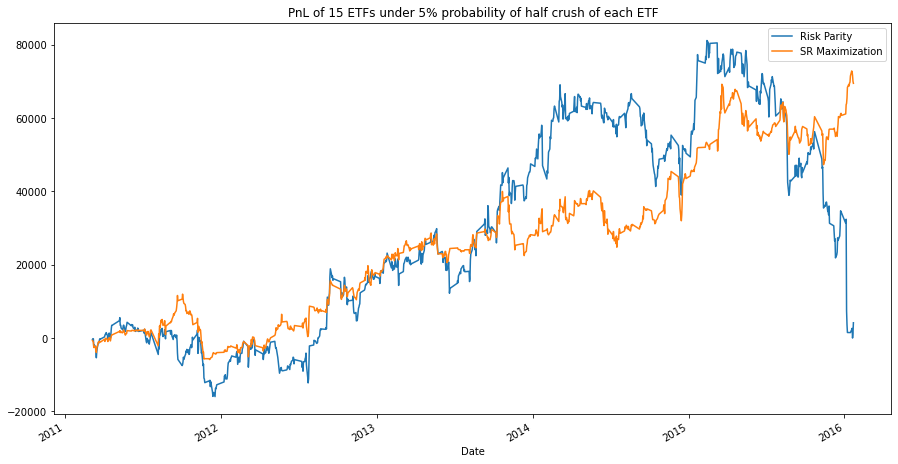

In [52]:
PnL_rp.cumsum().plot(figsize=(15,8), label='Risk Parity')
PnL_sr.cumsum().plot(figsize=(15,8), label='SR Maximization')

plt.title('PnL of 15 ETFs under 5% probability of half crush of each ETF')
plt.legend()
plt.show()

In [53]:
print(f'Max drawdown for Risk parity: {max_drawdown_rp}')
overallrisk_rp

Max drawdown for Risk parity: -119.66000000000001%


VaR 95%       VaR 99%      CVaR 95%      CVaR 99%
Period                                                       
1      -2039.784047  -2271.896507  -2155.840277  -2271.896507
2       -994.835701  -1801.449972  -1398.142837  -1801.449972
3      -2298.823555  -3820.796770  -3059.810163  -3820.796770
4      -1272.840243  -1408.890792  -1340.865518  -1408.890792
5      -1605.672045  -2881.302363  -2243.487204  -2881.302363
6      -5080.610278  -7318.315259  -6199.462769  -7318.315259
7      -3194.729840  -3433.684905  -3314.207373  -3433.684905
8      -1589.423069  -2760.529613  -2174.976341  -2760.529613
9      -5327.520032  -6742.993533  -6035.256783  -6742.993533
10     -2231.519542  -2360.222948  -2295.871245  -2360.222948
11     -1465.696727  -1494.757524  -1480.227126  -1494.757524
12     -1611.180798  -4551.381915  -3081.281357  -4551.381915
13     -2726.233266  -5894.418048  -4310.325657  -5894.418048
14     -1783.518984  -2036.653943  -1910.086463  -2036.653943
15     -1639.225187  -2182.528174  -1910.876680  -2182.528174
16     -1419.989405  -1850.709046  -1635.349226  -1850.709046
17     -3706.297714  -4046.375214  -3876.336464  -4046.375214
18     -2145.713991  -2779.086011  -2462.400001  -2779.086011
19     -2622.782220  -3508.532835  -3065.657527  -3508.532835
20     -3567.039591  -4803.883473  -4185.461532  -4803.883473
21     -1889.448976  -3466.483006  -2677.965991  -3466.483006
22     -1512.869779  -2732.953178  -2122.911478  -2732.953178
23     -1567.452385  -2095.136786  -1831.294586  -2095.136786
24     -4390.994508  -5507.454885  -4949.224697  -5507.454885
25     -1385.772444  -1742.044300  -1563.908372  -1742.044300
26     -2817.523430  -4309.121971  -3563.322700  -4309.121971
27     -3882.861650  -5358.588402  -4620.725026  -5358.588402
28     -4593.300401  -6049.676703  -5321.488552  -6049.676703
29     -1440.709403  -1558.721127  -1499.715265  -1558.721127
30     -3261.749045  -6816.448716  -5039.098881  -6816.448716
31     -4267.180207  -5050.959213  -4659.069710  -5050.959213
32     -2777.542686  -4141.025247  -3459.283967  -4141.025247
33     -4615.784275  -5605.068214  -5110.426245  -5605.068214
34     -1722.173754  -3014.626230  -2368.399992  -3014.626230
35     -5280.548430  -9183.809815  -7232.179123  -9183.809815
36     -1669.273409  -3798.529732  -2733.901570  -3798.529732
37     -6897.675635  -7772.143177  -7334.909406  -7772.143177
38     -2485.661559  -4154.211873  -3319.936716  -4154.211873
39     -2513.482931  -3674.761827  -3094.122379  -3674.761827
40     -2758.305842  -3189.013717  -2973.659780  -3189.013717
41     -5595.603324  -6980.989104  -6288.296214  -6980.989104
42     -2451.833805  -3667.396507  -3059.615156  -3667.396507
43     -3232.795444  -5166.172232  -4199.483838  -5166.172232
44     -3261.310166  -3898.613648  -3579.961907  -3898.613648
45     -1893.178572  -2304.497653  -2098.838112  -2304.497653
46     -4486.067454  -6333.087164  -5409.577309  -6333.087164
47     -3709.820893  -4125.117378  -3917.469135  -4125.117378
48     -7833.094339  -7833.094339  -7833.094339  -7833.094339
49     -6573.380566  -9178.024966  -7875.702766  -9178.024966
50     -3716.035075  -4305.628042  -4010.831558  -4305.628042
51     -6136.545032 -10433.958882  -8285.251957 -10433.958882
52     -3566.074383  -7263.149225  -5414.611804  -7263.149225
53     -4103.532035  -5638.665487  -4871.098761  -5638.665487
54     -7605.800356 -12710.328737 -10158.064547 -12710.328737
55     -5364.986435  -6480.568731  -5922.777583  -6480.568731
56     -2372.980548  -3060.160558  -2716.570553  -3060.160558
57     -5802.644157  -9460.290678  -7631.467417  -9460.290678
58     -3479.075984  -6187.585715  -4833.330850  -6187.585715
59     -7047.435702 -26155.687946 -16601.561824 -26155.687946

In [54]:
print(f'Max drawdown for Risk parity: {max_drawdown_sr}')
overallrisk_sr

Max drawdown for Risk parity: -108.02000000000001%


VaR 95%       VaR 99%     CVaR 95%      CVaR 99%
Period                                                      
1      -1007.301687  -1653.850814 -1330.576251  -1653.850814
2       -728.623205  -1029.124971  -878.874088  -1029.124971
3       -833.195915  -1767.892266 -1300.544091  -1767.892266
4       -255.989942   -354.987609  -305.488775   -354.987609
5      -1444.542419  -1630.679819 -1537.611119  -1630.679819
6      -4057.890898  -5408.258475 -4733.074687  -5408.258475
7       -841.751842  -1629.195619 -1235.473730  -1629.195619
8      -2054.771316  -2802.422309 -2428.596813  -2802.422309
9      -3541.724689  -4102.924460 -3822.324574  -4102.924460
10      -348.289466   -757.505696  -552.897581   -757.505696
11      -494.341321   -722.092037  -608.216679   -722.092037
12     -1017.822293  -1842.641386 -1430.231839  -1842.641386
13     -1457.519959  -3261.393998 -2359.456979  -3261.393998
14      -973.305939  -1041.300415 -1007.303177  -1041.300415
15     -1983.224399  -2430.584922 -2206.904661  -2430.584922
16     -1087.077557  -1222.104523 -1154.591040  -1222.104523
17     -2899.010911  -3048.062366 -2973.536638  -3048.062366
18     -1235.140460  -1908.210933 -1571.675696  -1908.210933
19     -1881.920760  -2476.130889 -2179.025825  -2476.130889
20     -1943.593598  -2506.826099 -2225.209849  -2506.826099
21     -1092.533018  -1184.512502 -1138.522760  -1184.512502
22     -1509.962234  -1872.875535 -1691.418884  -1872.875535
23     -1838.731711  -2413.847958 -2126.289835  -2413.847958
24     -1789.452477  -2419.838627 -2104.645552  -2419.838627
25     -1294.398010  -1368.693942 -1331.545976  -1368.693942
26     -1834.207217  -1928.359918 -1881.283567  -1928.359918
27     -3125.198430  -3406.794340 -3265.996385  -3406.794340
28     -1980.481842  -2429.862186 -2205.172014  -2429.862186
29      -491.251652  -2642.561364 -1566.906508  -2642.561364
30     -2534.452077  -5677.903709 -4106.177893  -5677.903709
31     -1264.490271  -1539.480645 -1401.985458  -1539.480645
32     -2681.902693  -2967.915593 -2824.909143  -2967.915593
33     -4337.544151  -4669.827410 -4503.685780  -4669.827410
34     -1372.090765  -2232.966274 -1802.528520  -2232.966274
35     -2986.571989  -6972.540984 -4979.556487  -6972.540984
36      -634.942483  -1501.600241 -1068.271362  -1501.600241
37     -6781.803299  -7779.207869 -7280.505584  -7779.207869
38     -1361.769748  -2215.013309 -1788.391529  -2215.013309
39     -1631.673370  -2030.645704 -1831.159537  -2030.645704
40     -4437.064725  -5954.908626 -5195.986676  -5954.908626
41     -3713.929501  -4718.158345 -4216.043923  -4718.158345
42      -899.697847  -1043.948404  -971.823126  -1043.948404
43     -1513.591465  -2535.809672 -2024.700568  -2535.809672
44     -1373.411805  -1700.122087 -1536.766946  -1700.122087
45     -1889.597205  -2815.037529 -2352.317367  -2815.037529
46     -3790.114594  -4698.348880 -4244.231737  -4698.348880
47      -883.938825  -1051.864406  -967.901616  -1051.864406
48     -3416.136135  -3416.136135 -3416.136135  -3416.136135
49     -4832.250328  -6420.468973 -5626.359651  -6420.468973
50     -1593.357115  -2191.522193 -1892.439654  -2191.522193
51     -4936.316047  -5197.570516 -5066.943282  -5197.570516
52     -2797.326341  -2948.806455 -2873.066398  -2948.806455
53      -871.897687  -1295.560227 -1083.728957  -1295.560227
54     -6704.740885 -10381.741856 -8543.241370 -10381.741856
55     -1796.773465  -1841.271081 -1819.022273  -1841.271081
56     -2445.746616  -3187.861804 -2816.804210  -3187.861804
57     -4767.338202  -5690.164332 -5228.751267  -5690.164332
58     -2091.846338  -2447.962710 -2269.904524  -2447.962710
59     -1726.646536  -3289.189912 -2507.918224  -3289.189912

In [63]:
# Market crush scenario
opt_sa1 = portfolio_optimizer(semiannual_bt)

# Risk parity
dollar_full_portfolio_rp, PnL_rp,usdrisk_rp,cadrisk_rp,overallrisk_rp, max_drawdown_rp,sharpe_rp,_finalweights_rp = opt_sa1.portfolio_simulator(100000, riskfree, top15_bt, 15, VaRcutoff, 'Risk parity', scenario='MV ETF crash')
# Sharpe Ratio Maximization
dollar_full_portfolio_sr, PnL_sr,usdrisk_sr,cadrisk_sr,overallrisk_sr, max_drawdown_sr,sharpe_sr,_finalweights_sr = opt_sa1.portfolio_simulator(100000, riskfree, top15_bt, 15, VaRcutoff, 'Sharpe ratio maximization', scenario='MV ETF crash')

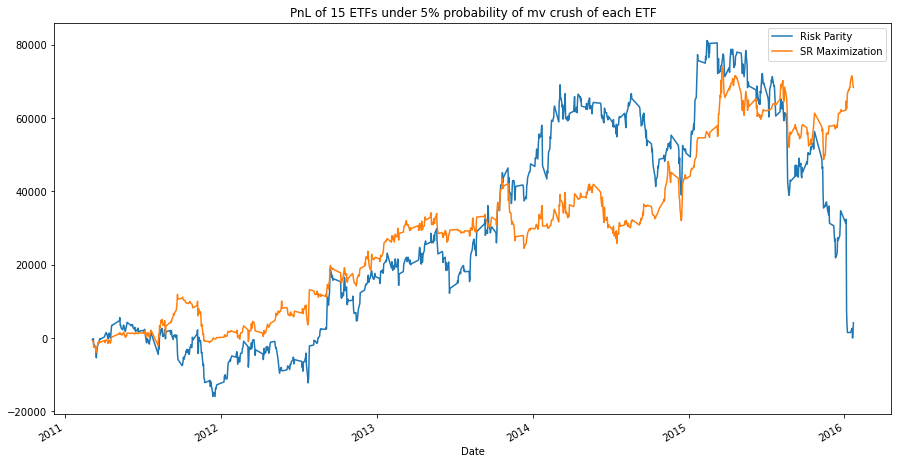

In [64]:
PnL_rp.cumsum().plot(figsize=(15,8), label='Risk Parity')
PnL_sr.cumsum().plot(figsize=(15,8), label='SR Maximization')

plt.title('PnL of 15 ETFs under 5% probability of mv crush of each ETF')
plt.legend()
plt.show()

In [65]:
print(f'Max drawdown for Risk parity: {max_drawdown_rp}')
overallrisk_rp

Max drawdown for Risk parity: -119.66000000000001%


VaR 95%       VaR 99%      CVaR 95%      CVaR 99%
Period                                                       
1      -2039.784075  -2271.896473  -2155.840274  -2271.896473
2       -994.835608  -1801.449881  -1398.142744  -1801.449881
3      -2298.823551  -3820.796746  -3059.810149  -3820.796746
4      -1272.840227  -1408.890792  -1340.865510  -1408.890792
5      -1605.672257  -2881.302672  -2243.487464  -2881.302672
6      -5080.610201  -7318.315113  -6199.462657  -7318.315113
7      -3194.729632  -3433.685447  -3314.207540  -3433.685447
8      -1589.422918  -2760.529751  -2174.976335  -2760.529751
9      -5327.521487  -6742.995174  -6035.258331  -6742.995174
10     -2231.520904  -2360.224342  -2295.872623  -2360.224342
11     -1465.697240  -1494.758375  -1480.227808  -1494.758375
12     -1611.180842  -4551.381765  -3081.281304  -4551.381765
13     -2726.233322  -5894.418197  -4310.325760  -5894.418197
14     -1783.518911  -2036.653978  -1910.086445  -2036.653978
15     -1639.225220  -2182.528247  -1910.876733  -2182.528247
16     -1419.989574  -1850.709079  -1635.349327  -1850.709079
17     -3706.298222  -4046.376990  -3876.337606  -4046.376990
18     -2145.714290  -2779.085900  -2462.400095  -2779.085900
19     -2622.782266  -3508.533004  -3065.657635  -3508.533004
20     -3567.039626  -4803.883470  -4185.461548  -4803.883470
21     -1889.449004  -3466.483013  -2677.966009  -3466.483013
22     -1512.869483  -2732.953147  -2122.911315  -2732.953147
23     -1567.452394  -2095.136849  -1831.294621  -2095.136849
24     -4390.994394  -5507.454768  -4949.224581  -5507.454768
25     -1385.772535  -1742.044299  -1563.908417  -1742.044299
26     -2817.523456  -4309.122098  -3563.322777  -4309.122098
27     -3882.861688  -5358.588695  -4620.725191  -5358.588695
28     -4593.300485  -6049.677135  -5321.488810  -6049.677135
29     -1440.709628  -1558.720934  -1499.715281  -1558.720934
30     -3261.750091  -6816.450090  -5039.100091  -6816.450090
31     -4267.180326  -5050.959545  -4659.069935  -5050.959545
32     -2777.543184  -4141.025747  -3459.284466  -4141.025747
33     -4615.784227  -5605.068346  -5110.426287  -5605.068346
34     -1722.174007  -3014.626473  -2368.400240  -3014.626473
35     -5280.548668  -9183.810119  -7232.179393  -9183.810119
36     -1669.273522  -3798.529852  -2733.901687  -3798.529852
37     -6897.675960  -7772.143374  -7334.909667  -7772.143374
38     -2485.661513  -4154.212029  -3319.936771  -4154.212029
39     -2513.482971  -3674.761783  -3094.122377  -3674.761783
40     -2758.305853  -3189.013857  -2973.659855  -3189.013857
41     -5595.602835  -6980.989087  -6288.295961  -6980.989087
42     -2451.833952  -3667.396692  -3059.615322  -3667.396692
43     -3232.795498  -5166.172972  -4199.484235  -5166.172972
44     -3261.310478  -3898.614015  -3579.962247  -3898.614015
45     -1893.178613  -2304.497753  -2098.838183  -2304.497753
46     -4486.067813  -6333.087860  -5409.577836  -6333.087860
47     -3709.822220  -4125.117154  -3917.469687  -4125.117154
48     -7833.094339  -7833.094339  -7833.094339  -7833.094339
49     -6573.380734  -9178.024946  -7875.702840  -9178.024946
50     -3716.035261  -4305.628285  -4010.831773  -4305.628285
51     -6136.545232 -10433.959316  -8285.252274 -10433.959316
52     -3566.074817  -7263.149508  -5414.612162  -7263.149508
53     -4103.532054  -5638.665480  -4871.098767  -5638.665480
54     -7605.800485 -12710.328861 -10158.064673 -12710.328861
55     -5364.987084  -6480.569563  -5922.778324  -6480.569563
56     -2372.980693  -3060.160667  -2716.570680  -3060.160667
57     -5802.644145  -9460.291433  -7631.467789  -9460.291433
58     -3479.075924  -6187.585551  -4833.330738  -6187.585551
59     -7047.436845 -26155.691342 -16601.564094 -26155.691342

In [66]:
print(f'Max drawdown for Risk parity: {max_drawdown_sr}')
overallrisk_sr

Max drawdown for Risk parity: -105.25999999999999%


VaR 95%       VaR 99%     CVaR 95%      CVaR 99%
Period                                                      
1       -995.652445  -1639.360457 -1317.506451  -1639.360457
2       -709.487622  -1042.061130  -875.774376  -1042.061130
3       -841.515639  -1751.556657 -1296.536148  -1751.556657
4       -268.600015   -331.045214  -299.822614   -331.045214
5      -1325.778304  -1466.987288 -1396.382796  -1466.987288
6      -4042.820696  -5357.814193 -4700.317445  -5357.814193
7       -929.780001  -1437.650855 -1183.715428  -1437.650855
8       -715.810694  -1001.785334  -858.798014  -1001.785334
9      -3506.744570  -4297.231912 -3901.988241  -4297.231912
10      -429.478439   -595.116771  -512.297605   -595.116771
11      -469.620057   -744.349019  -606.984538   -744.349019
12     -1043.180077  -1611.433411 -1327.306744  -1611.433411
13     -1569.921646  -3400.332244 -2485.126945  -3400.332244
14      -981.498097  -1054.528951 -1018.013524  -1054.528951
15     -1809.172890  -2307.143944 -2058.158417  -2307.143944
16     -1102.859351  -1261.486091 -1182.172721  -1261.486091
17     -3115.741581  -3288.346790 -3202.044185  -3288.346790
18     -1262.237652  -1987.088036 -1624.662844  -1987.088036
19     -1708.949602  -2341.165415 -2025.057509  -2341.165415
20     -2198.490334  -2533.310030 -2365.900182  -2533.310030
21     -1122.292173  -1137.569846 -1129.931009  -1137.569846
22     -1427.125945  -1881.074156 -1654.100051  -1881.074156
23     -1566.902511  -1826.078486 -1696.490499  -1826.078486
24     -1798.612385  -2362.769550 -2080.690968  -2362.769550
25     -1305.171941  -1344.574305 -1324.873123  -1344.574305
26     -1702.781461  -2414.366937 -2058.574199  -2414.366937
27     -3148.801738  -3461.871216 -3305.336477  -3461.871216
28     -2376.545857  -2565.462265 -2471.004061  -2565.462265
29      -549.914068  -2511.569825 -1530.741946  -2511.569825
30     -2828.801114  -6069.845372 -4449.323243  -6069.845372
31     -1306.178920  -1383.962621 -1345.070770  -1383.962621
32     -2829.784082  -3102.998733 -2966.391407  -3102.998733
33     -4404.308095  -4603.233784 -4503.770939  -4603.233784
34     -1415.165300  -2347.331779 -1881.248539  -2347.331779
35     -2715.574189  -6022.125163 -4368.849676  -6022.125163
36      -464.981032  -1363.443761  -914.212397  -1363.443761
37     -5959.734264  -7629.456897 -6794.595580  -7629.456897
38     -1007.625228  -2183.827110 -1595.726169  -2183.827110
39     -1667.873727  -1945.725399 -1806.799563  -1945.725399
40     -5077.989661  -6722.280923 -5900.135292  -6722.280923
41     -3864.857003  -5627.540430 -4746.198717  -5627.540430
42      -883.079481  -1498.846396 -1190.962938  -1498.846396
43     -1549.624544  -2634.578104 -2092.101324  -2634.578104
44     -1188.884739  -1645.523520 -1417.204129  -1645.523520
45     -1967.982662  -2267.942287 -2117.962475  -2267.942287
46     -4116.643282  -4429.294606 -4272.968944  -4429.294606
47      -869.687432  -1065.681206  -967.684319  -1065.681206
48     -3560.873975  -3560.873975 -3560.873975  -3560.873975
49     -5173.891600  -6219.733099 -5696.812350  -6219.733099
50     -1533.083824  -2276.265145 -1904.674485  -2276.265145
51     -4758.596690  -4911.133317 -4834.865003  -4911.133317
52     -3010.826392  -3169.546296 -3090.186344  -3169.546296
53      -374.367250   -644.548175  -509.457713   -644.548175
54     -7087.739729 -11079.100605 -9083.420167 -11079.100605
55     -1120.333605  -1353.696296 -1237.014950  -1353.696296
56     -2495.156165  -2998.957644 -2747.056904  -2998.957644
57     -4500.823428  -5391.067488 -4945.945458  -5391.067488
58     -1180.638605  -1388.327864 -1284.483234  -1388.327864
59     -1880.238439  -5284.961894 -3582.600167  -5284.961894